# One-Hour-Ahead Energy Consumption Forecasting Using LSTM Networks

This work estimates future household energy consumption based on past measurements. LSTM (Long Short-Term Memory) models capture temporal dependencies and nonlinear relationships between electrical variables more effectively than traditional statistical methods, making them highly suitable for short-term load forecasting and consumption pattern recognition.

*Goal:*
Perform a one-hour-ahead prediction of household Global Active Power (column: 'global_active_power') using an LSTM network, followed by a visual comparison between predicted and actual values on the test set.

*Dataset:*
The dataset used is the Individual Household Electric Power Consumption dataset (UCI Machine Learning Repository, ID 235), containing minute-by-minute measurements recorded between December 2006 and November 2010 from a single household in France.
Each record includes timestamp, global active and reactive power, voltage, current intensity, and sub-metered energy for three circuits.
The data were resampled to hourly averages and normalized to enable efficient time-series forecasting and accurate temporal learning.

The datasets presented in this repository are an adapted and preprocessed version of the original one. They only required normalization and sequence generation.

*Pre-Requisites:*
Basic understanding of temporal series and their structure.

* LINK of original dataset: https://www.kaggle.com/datasets/uciml/electric-power-consumption-data-set/discussion/code?sort=hotness
* Adapted from: https://www.kaggle.com/code/cuge1995/lstm-for-household-electric-power-cb225cfe-1\
⚙️ Programming specifications and architectural details are presented in the following sections.

## 1. Setup and Imports

In [33]:
# IMPORTS
import os
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
# REPRODUCIBILITY
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# CHECK WORKING DIRECTORY
print(f"Working directory: {os.getcwd()}")

Working directory: c:\Users\RP\Downloads


## 2. Load Data and Exploratory Analysis

In [34]:
# 1️⃣ Load each split dataset from CSV
train_df_o = pd.read_csv("train_power_hourly.csv", parse_dates=['datetime'])
val_df_o   = pd.read_csv("val_power_hourly.csv",  parse_dates=['datetime'])
test_df_o  = pd.read_csv("test_power_hourly.csv", parse_dates=['datetime'])


# 2️⃣ Verify datetime ranges for each subset
print("Train range:", train_df_o['datetime'].min(), "→", train_df_o['datetime'].max())
print("Val range:",   val_df_o['datetime'].min(),   "→", val_df_o['datetime'].max())
print("Test range:",  test_df_o['datetime'].min(),  "→", test_df_o['datetime'].max())

# 3️⃣ Inspect structure and first records
print("\n🔹 Training set structure:")
train_df_o.info()          # Overview of columns, dtypes, and non-null counts
print("\n🔹 First rows of training data:")
print(train_df_o.head())   # Display first few rows to confirm format


Train range: 2006-12-16 17:00:00 → 2007-10-04 16:00:00
Val range: 2007-10-04 17:00:00 → 2007-11-10 04:00:00
Test range: 2007-11-10 05:00:00 → 2007-12-16 17:00:00

🔹 Training set structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7008 entries, 0 to 7007
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   global_active_power    7008 non-null   float64       
 1   global_reactive_power  7008 non-null   float64       
 2   voltage                7008 non-null   float64       
 3   global_intensity       7008 non-null   float64       
 4   sub_metering_1         7008 non-null   float64       
 5   sub_metering_2         7008 non-null   float64       
 6   sub_metering_3         7008 non-null   float64       
 7   datetime               7008 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(7)
memory usage: 438.1 KB

🔹 First rows of training data:
   global_active_power

## 3. Preprocessing

The file “household_power_hourly.csv” contains hourly aggregated measurements of household electric power consumption, obtained after a preprocessing phase involving data cleaning, resampling, and interpolation and already split chronologically into training (80%), validation (10%), and testing (10%) subsets.

This preprocessing pipeline was designed to transform the raw data into a continuous, model-ready time series suitable for forecasting. The main steps were as follows:

* All numerical features were normalized to the [-1, 1] range using a Min-Max Scaler fitted exclusively on the training data to avoid data leakage.

* Sliding windows of 24 consecutive hours were then generated to create input sequences (X) and corresponding prediction targets (y).

This process ensured that the dataset was fully structured and optimized for time-series learning

### 3.1 Normalization (Fit on Train Only)

All numerical features are scaled to the [-1, 1] range using the Min–Max normalization.
The scaler is fit only on the training data and applied to validation and test sets — ensuring realistic generalization.

In [35]:
# Initialize the Min-Max Scaler
scaler = MinMaxScaler(feature_range=(-1, 1))

# Fit the scaler ONLY on training data
train_scaled = scaler.fit_transform(train_df_o.drop(columns=['datetime']))

# Apply the same scaler to validation and test sets
val_scaled  = scaler.transform(val_df_o.drop(columns=['datetime']))
test_scaled = scaler.transform(test_df_o.drop(columns=['datetime']))

# Get list of numeric columns (excluding datetime)
numeric_cols = train_df_o.drop(columns=['datetime']).columns

#  Rebuild scaled DataFrames, adding datetime back
train_df = pd.DataFrame(train_scaled, columns=numeric_cols)
train_df['datetime'] = train_df_o['datetime']

val_df = pd.DataFrame(val_scaled, columns=numeric_cols)
val_df['datetime'] = val_df_o['datetime']

test_df = pd.DataFrame(test_scaled, columns=numeric_cols)
test_df['datetime'] = test_df_o['datetime']

# Check shapes and first few rows of scaled data
print("Train shape:", train_df.shape)
print("Val shape:", val_df.shape)
print("Test shape:", test_df.shape)
print(train_df.head())

Train shape: (7008, 8)
Val shape: (876, 8)
Test shape: (877, 8)
   global_active_power  global_reactive_power   voltage  global_intensity  \
0             0.312150              -0.249534 -0.281101          0.290656   
1             0.122375              -0.787093 -0.286301          0.105995   
2             0.047849              -0.768329 -0.396279          0.024991   
3             0.005547              -0.804896 -0.327811         -0.018343   
4            -0.062596              -0.799242 -0.075880         -0.082605   

   sub_metering_1  sub_metering_2  sub_metering_3            datetime  
0            -1.0       -0.973644        0.795327 2006-12-16 17:00:00  
1            -1.0       -0.664586        0.795918 2006-12-16 18:00:00  
2            -1.0       -0.928423        0.776398 2006-12-16 19:00:00  
3            -1.0       -1.000000        0.787045 2006-12-16 20:00:00  
4            -1.0       -0.979193        0.833185 2006-12-16 21:00:00  


### 3.2 Sequence Generation for Forecasting

This section shows Keras’s built-in TimeseriesGenerator, which automatically builds sequential input–output pairs for time-series forecasting.

* Each generator uses a window size of 24, meaning the model sees the past 24 hourly steps to predict the next one.

* The data parameter contains all numerical features (excluding datetime), while targets correspond to the global_active_power column.

* The length argument defines the window size, and batch_size determines how many samples are processed together (here, the entire dataset is used as one batch for convenience).

* Setting shuffle=False preserves the chronological order — critical for time-dependent data.

* Finally, by calling train_gen[0], val_gen[0], and test_gen[0], the code extracts all sequences and targets directly into (x, y) arrays.

This approach is cleaner, safer, and less error-prone than manually slicing arrays, ensuring consistent alignment between input sequences and target values.

In [36]:
window_size = 24
batch_size = len(train_df)  # use one batch for convenience


# Training generator
train_gen = TimeseriesGenerator(
    data=train_df.drop(columns=['datetime']).values,
    targets=train_df['global_active_power'].values,
    length=window_size,
    batch_size=batch_size,
    shuffle=False
)

# Validation generator
val_gen = TimeseriesGenerator(
    data=val_df.drop(columns=['datetime']).values,
    targets=val_df['global_active_power'].values,
    length=window_size,
    batch_size=len(val_df),
    shuffle=False
)

# Test generator
test_gen = TimeseriesGenerator(
    data=test_df.drop(columns=['datetime']).values,
    targets=test_df['global_active_power'].values,
    length=window_size,
    batch_size=len(test_df),
    shuffle=False
)

X_train, y_train = train_gen[0]
X_val, y_val     = val_gen[0]
X_test, y_test   = test_gen[0]

print(f"✅ X_train shape: {X_train.shape}")
print(f"✅ X_val shape:   {X_val.shape}")
print(f"✅ X_test shape:  {X_test.shape}")

# Check for NaNs before training
print("NaNs in X_train:", np.isnan(X_train).sum())
print("NaNs in y_train:", np.isnan(y_train).sum())


✅ X_train shape: (6984, 24, 7)
✅ X_val shape:   (852, 24, 7)
✅ X_test shape:  (853, 24, 7)
NaNs in X_train: 0
NaNs in y_train: 0


## 4. Build & Train the Model 

This section defines and trains an LSTM model designed for time-series regression.
The network learns temporal patterns in hourly power consumption data, using callbacks to control overfitting [Early Stopping].

In [37]:
# Define number of features and batch size
num_features = X_train.shape[2]   # number of input variables per timestep

# ============================================
# BUILD MODEL
model = Sequential([
    tf.keras.layers.Input(shape=(window_size, num_features)),  # input: 24-hour window
    tf.keras.layers.LSTM(64),                                  # LSTM layer with 64 units
    tf.keras.layers.Dropout(0.3),                              # prevent overfitting
    tf.keras.layers.Dense(32, activation='relu'),              # dense layer for feature extraction
    tf.keras.layers.Dense(1, activation='linear')              # output: continuous regression value
])

# Compile model with optimizer, loss, and evaluation metric
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',                  # minimize mean squared error
    metrics=['mae']              # track mean absolute error
)

# Display model summary
model.summary()

# Create callbacks for training
callbacks = [
    EarlyStopping(
        monitor='val_loss',       # watch validation loss
        patience=10,              # stop if no improvement for 10 epochs
        restore_best_weights=True # revert to best model weights
    )
]

# ============================================
# TRAIN THE MODEL
history = model.fit(
    X_train, y_train,
    epochs=40,                   # maximum number of epochs
    batch_size=128 ,       # defined earlier
    validation_data=(X_val, y_val),
    callbacks=callbacks,         # early stopping and LR scheduling
    verbose=1
)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 64)             │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,545 (80.25 KB)

 Trainable params: 20,545 (80.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1300 - mae: 0.2782 - val_loss: 0.0755 - val_mae: 0.2043
Epoch 2/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0750 - mae: 0.2112 - val_loss: 0.0662 - val_mae: 0.1944
Epoch 3/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0648 - mae: 0.1940 - val_loss: 0.0576 - val_mae: 0.1722
Epoch 4/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0579 - mae: 0.1809 - val_loss: 0.0514 - val_mae: 0.1724
Epoch 5/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0533 - mae: 0.1717 - val_loss: 0.0465 - val_mae: 0.1549
Epoch 6/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0501 - mae: 0.1664 - val_loss: 0.0447 - val_mae: 0.1573
Epoch 7/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0482 - mae: 0.1627 - val_loss: 0.0426 - val_mae: 0.1486
Epoch 8/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0475 - mae: 0.1607 - val_loss: 0.0420 - val_mae: 0.1468
Epoch 9/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.046

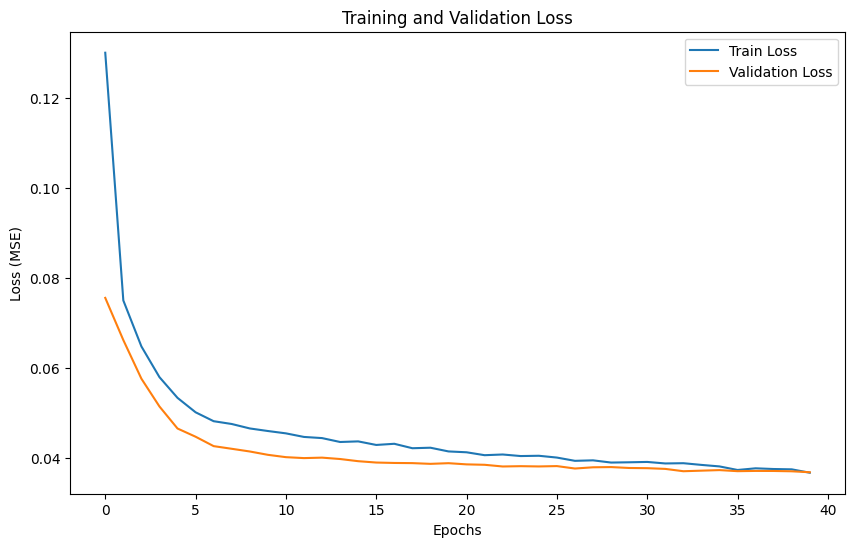

In [38]:
# PLOT TRAINING CURVES
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')      # training loss over epochs
plt.plot(history.history['val_loss'], label='Validation Loss')  # validation loss
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.show()


### 5. Evaluate the Model

This section evaluates the trained model on the test dataset to assess its predictive performance on unseen data. The evaluation includes the computation of key regression metrics, which together quantify both the magnitude and consistency of prediction errors:
* Mean Squared Error (MSE);
* Mean Absolute Error (MAE);
* Root Mean Squared Error (RMSE);
* R² .

Before calculating these metrics, the predicted values are flattened using the .flatten() method to ensure dimensional compatibility between y_pred and y_test, as the model outputs a two-dimensional array (n_samples, 1) while the ground truth is one-dimensional (n_samples,).

In [39]:
# Evaluate model on test data
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)

# Predict on test set
y_pred = model.predict(X_test).flatten()

# Compute complementary metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

# Display results
print(f"\n📈 Model performance on test set:")
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE:        {test_mae:.4f}")
print(f"Test RMSE:       {rmse:.4f}")
print(f"Test R²:         {r2:.4f}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0506 - mae: 0.1597
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

📈 Model performance on test set:
Test Loss (MSE): 0.0506
Test MAE:        0.1597
Test RMSE:       0.2249
Test R²:         0.5921


#### Model Evaluation Summary

Overall, the model generalizes well and follows main trends but struggles with sudden changes. Further improvement could come from adding external features, tuning hyperparameters, or testing alternative architectures (e.g., GRU). More specifically:

* MSE (0.0506): Indicates low average squared error — the model captures main patterns but still produces some larger deviations.

* MAE (0.1597): On normalized data, the model’s average error is about 16%, which is reasonable for short-term forecasting.

* RMSE (0.2249): Higher than MAE, suggesting a few larger errors or spikes not well predicted.

* R² (0.5921): The model explains roughly 59% of the variance in power consumption — a solid baseline but not yet highly precise.



### 6. Visualization of Model Predictions
This final section provides a visual comparison between the actual and predicted power consumption values over a selected time window.
By plotting the first 200 test samples, the figure illustrates how closely the model’s forecasts follow the real consumption patterns.
The alignment between both curves indicates the model’s ability to capture short-term variations and overall temporal trends in household energy usage, confirming the consistency of its predictive performance.

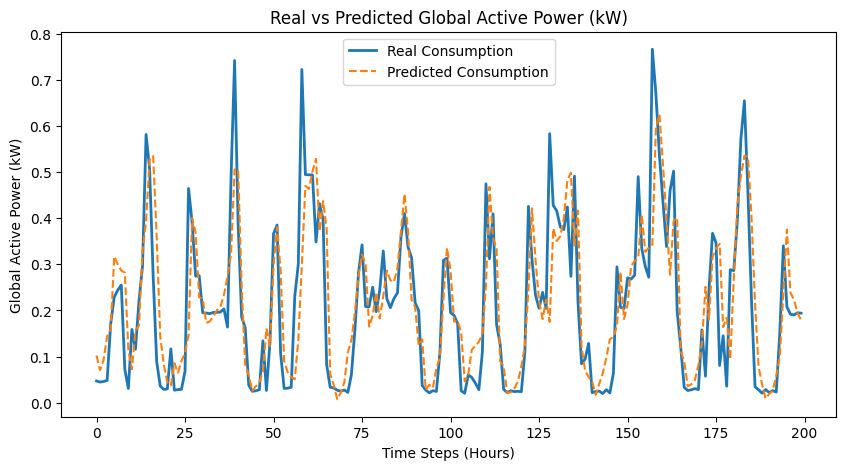

In [40]:
# Inverse transform predictions and true values
y_pred_full = np.zeros((len(y_pred), train_scaled.shape[1]))
y_pred_full[:, 0] = y_pred.flatten()
y_pred_inv = scaler.inverse_transform(y_pred_full)[:, 0]

y_test_full = np.zeros((len(y_test), train_scaled.shape[1]))
y_test_full[:, 0] = y_test.flatten()
y_test_inv = scaler.inverse_transform(y_test_full)[:, 0]



# Plot real vs predicted values
plt.figure(figsize=(10,5))
plt.plot(y_test_inv[:200], label='Real Consumption', linewidth=2)
plt.plot(y_pred_inv[:200], label='Predicted Consumption', linestyle='--')
plt.title("Real vs Predicted Global Active Power (kW)")
plt.xlabel("Time Steps (Hours)")
plt.ylabel("Global Active Power (kW)")
plt.legend()
plt.show()


### Conclusions

The LSTM model effectively captured temporal patterns in hourly household power consumption, showing consistent performance across training, validation, and test sets.
The preprocessing pipeline — including resampling, normalization, and sequence generation — ensured clean, structured input suitable for time-series forecasting.
Evaluation metrics (MAE, RMSE, R²) and visual comparisons confirmed the model’s ability to produce accurate and stable short-term predictions.
While further optimization and additional features could enhance performance, the results demonstrate the strong potential of recurrent neural networks for energy consumption forecasting.
